# Trabalho Prático 1 - Implementação KNN

Neste notebook será implementado um algoritmo de KNN para criar um modelo, que será usado para prever quais passegeiros obreviveram ao naufágio do Titanic.

## Sumário
1. Implementação do Algoritmo KNN
2. Setup e tratamento dos dados
3. Aplicação e avaliação do modelo

In [1]:
# importação das bibliotecas e pacotes usados neste notebook
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report


### 1. Implementação do Algoritmo para criar um modelo KNN

In [2]:
class KNN():
    
    def __init(self):
        self.K = None
        self.X_train = None
        self.y_train = None
        self.vizinhos_index = None
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X, K=1):
        self.K = K
        classes = np.unique(self.y_train)
        y_pred = []
        dist_total = []
        self.vizinhos_index = []

        for xi in X:
            euclidistancias = -2 * xi @ self.X_train.T + (xi**2).sum() + (self.X_train**2).sum(axis=1)
            
            
            knn_index = np.argsort(euclidistancias)[0:K]
            self.vizinhos_index.append(knn_index)
            contagem = []
            dist_total = []
            
            for classe in classes:
                contagem.append((self.y_train[knn_index]==classe).sum())
                dist_classe = np.sum(euclidistancias[knn_index][self.y_train[knn_index]==classe])
                dist_total.append(dist_classe)
                
            contagem = np.array(contagem)
            
            #criar lista de classes empatadas
            indice_classes_empatadas = []
            for i in range(len(contagem)):
                if contagem[i] == max(contagem):
                    indice_classes_empatadas.append(i)
            
            # Popular y_pred com as duas regras de decisão: 
                # Se não empate: classe com maior votação
                # Se empate: classe com menor distância entre as classes empatadas
            
            dist_total = np.array(dist_total)

            if len(indice_classes_empatadas) == 1:
                pred_index = np.argmax(contagem)
                y_pred.append(classes[pred_index])
                
                
    
            else:
                # menor valor das distancias totais que estão com a mesma quantidade de votos
                menor_valor = np.min(dist_total[indice_classes_empatadas])
                
                # indice da menor distancia contando todas as distâncias
                indice_menor_dist = np.where(dist_total == menor_valor)[0][0]
                
                # Predição pra essa instância = Classe que tem a menor distancia
                y_pred.append(classes[indice_menor_dist])
            

            
        return np.array(y_pred)

### 2. Setup e exploração inicial

### Dataset Titanic

#### Descrição dos dados:

* y (Target) → 0 = Não sobreviveu, 1 = Sobreviveu → Categórica (transformada em numérica)
* pclass → Classe do bilhete → 1: Primeira classe, 2: Segunda classe, 3: Terceira classe (Categórica em forma de números)
* sex → Sexo (Categórica)
* Age → Idade em anos (numérica)
* sibsp → Número de irmãos / cônjuges abordo do titanic (numérica discreta)
* parch → Número de pais / filhos abordo (numérica discreta)
* ticket → Número do ticket (categórica em forma de número)
* fare → Valor do bilhete (numérico)
* cabin → id da cabine (complexa / mista)
* embarked → porto do embarque → C = Cherbourg, Q = Queenstown, S = Southampton

In [3]:
from sklearn.datasets import fetch_openml
titanic = fetch_openml(name='titanic',version = 1,as_frame=True)

In [4]:
X = titanic.data
X = X.drop(['boat', 'body', 'name', 'home.dest'], axis = 1)
y = titanic.target

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   float64 
 1   sex       1309 non-null   category
 2   age       1046 non-null   float64 
 3   sibsp     1309 non-null   float64 
 4   parch     1309 non-null   float64 
 5   ticket    1309 non-null   object  
 6   fare      1308 non-null   float64 
 7   cabin     295 non-null    object  
 8   embarked  1307 non-null   category
dtypes: category(2), float64(5), object(2)
memory usage: 74.5+ KB


In [6]:
X.isna().sum()

pclass         0
sex            0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
dtype: int64

* age, fare e embarked precisam ser preenchidos
* cabin pode ser dropado
* OBS: Instâncias de treino e "novas" devem ser preenchidas

In [7]:
X.head(2)

,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1.0,female,29.0000,0.0,0.0,24160,211.3375,B5,S
1,1.0,male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S


In [8]:
# Separando em treino e teste (25%)
X_train_, X_test, y_train_, y_test = train_test_split(X, y, test_size=0.25, random_state=13)
X_train_.shape, X_test.shape

((981, 9), (328, 9))

In [9]:
# Separando o treino em treino e validação (10% do treino)
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.10, random_state=13)
X_train.shape, X_val.shape

((882, 9), (99, 9))

In [10]:
X_train.head(2)

,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked
720,3.0,male,24.0,0.0,0.0,371109,7.25,None,Q
565,2.0,male,25.0,0.0,0.0,C.A. 29178,13.00,None,S


In [11]:
#Separar X_num e X_cat

num_cols = ['age', 'sibsp', 'parch', 'fare']
cat_cols = ['pclass', 'sex', 'embarked']

# Variáveis numéricas
* Explorar distribuições
* Imputar valores faltantes
* Transformar distribuição se necessário
* Detectar e tratar outliers (treino)
* Matriz de correlação
* Dropar variáveis se necessário

Text(0, 0.5, 'Frequency')

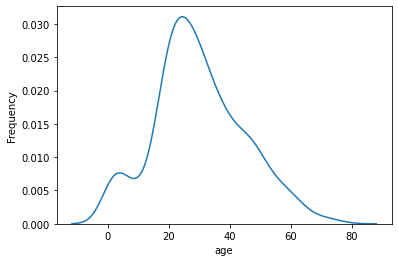

In [12]:
# Distribuição da feature age

g = sns.kdeplot(X_train["age"])
g.set_xlabel("age")
g.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

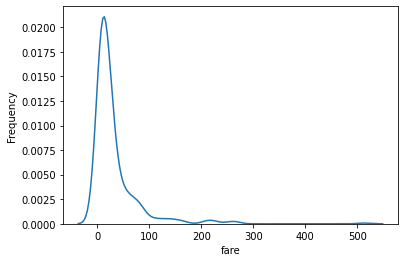

In [13]:
# Distribuição da feature fare

g = sns.kdeplot(X_train["fare"])
g.set_xlabel("fare")
g.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

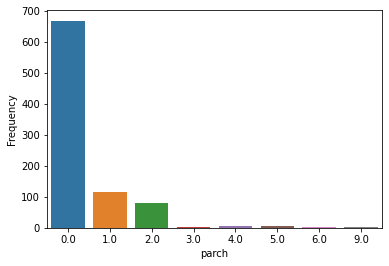

In [14]:
# Distribuição da feature parch


g = sns.countplot(x = X_train["parch"])
g.set_xlabel("parch")
g.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

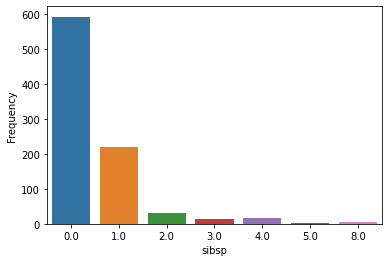

In [15]:
# Distribuição da feature sibsp


g = sns.countplot(x = X_train["sibsp"])
g.set_xlabel("sibsp")
g.set_ylabel("Frequency")

In [16]:
# Tratamento da feature age
# Imputação de dados nulos pela mediana

X_train['age'] = X_train['age'].fillna(X_train['age'].median())
X_val['age'] = X_val['age'].fillna(X_train['age'].median())
X_test['age'] = X_test['age'].fillna(X_train['age'].median())

Text(0, 0.5, 'Frequency')

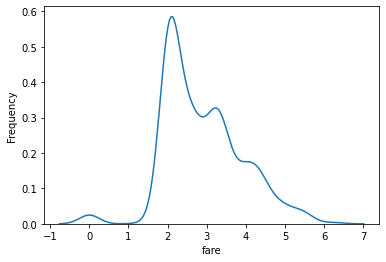

In [17]:
# Tratamento da feature fare
# Imputação de dados nulos pela mediana
# Log transformação

X_train['fare'] = X_train['fare'].fillna(X_train['fare'].median())
X_val['fare'] = X_val['fare'].fillna(X_train['fare'].median())
X_test['fare'] = X_test['fare'].fillna(X_train['fare'].median())

X_train["fare"] = X_train["fare"].map(lambda i: np.log(i) if i > 0 else 0)
X_val["fare"] = X_val["fare"].map(lambda i: np.log(i) if i > 0 else 0)
X_test["fare"] = X_test["fare"].map(lambda i: np.log(i) if i > 0 else 0)


g = sns.kdeplot(X_train["fare"])
g.set_xlabel("fare")
g.set_ylabel("Frequency")


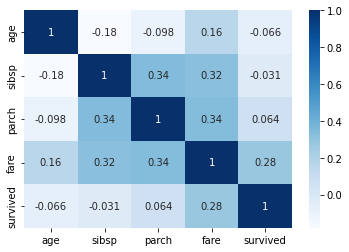

In [18]:
#Exploraração das correlações
temp = pd.concat([X_train[num_cols], y_train], axis = 1)
temp['survived'] = pd.to_numeric(temp['survived'])

corr_matrix = temp.corr()

g = sns.heatmap(corr_matrix ,cmap="Blues",annot=True)

In [19]:
X_train.head()

,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked
720,3.0,male,24.00,0.0,0.0,371109,1.981001,None,Q
565,2.0,male,25.00,0.0,0.0,C.A. 29178,2.564949,None,S
1182,3.0,female,21.00,0.0,0.0,343120,2.034706,None,S
1038,3.0,male,28.25,0.0,0.0,374746,2.085672,None,S
209,1.0,male,30.00,1.0,0.0,13236,4.056123,C78,C


* Apenas fare parece ter uma correlação significativa com a variável alvo

In [20]:
scaler = make_column_transformer(
    (StandardScaler(), ['age','fare']),
    remainder='passthrough')

scaler.fit(X_train)

scaled_train = scaler.transform(X_train)
scaled_val= scaler.transform(X_val)
scaled_test= scaler.transform(X_test)

X_train = pd.DataFrame(
    scaled_train, 
    columns= ['age','fare', 'pclass','sex', 'sibsp', 'parch', 'ticket', 'cabin', 'embarked']
)

X_val = pd.DataFrame(
    scaled_val, 
    columns= ['age','fare', 'pclass','sex', 'sibsp', 'parch', 'ticket', 'cabin', 'embarked']
)

X_test = pd.DataFrame(
    scaled_test, 
    columns= ['age','fare', 'pclass','sex', 'sibsp', 'parch', 'ticket', 'cabin', 'embarked']
)

In [21]:
scaler.get_feature_names_out()

array(['standardscaler__age', 'standardscaler__fare', 'remainder__pclass',
       'remainder__sex', 'remainder__sibsp', 'remainder__parch',
       'remainder__ticket', 'remainder__cabin', 'remainder__embarked'],
      dtype=object)

In [22]:
X_train.head()

,age,fare,pclass,sex,sibsp,parch,ticket,cabin,embarked
0,-0.426683,-0.927385,3.0,male,0.0,0.0,371109,None,Q
1,-0.350697,-0.33879,2.0,male,0.0,0.0,C.A. 29178,None,S
2,-0.654642,-0.873253,3.0,female,0.0,0.0,343120,None,S
3,-0.103742,-0.821881,3.0,male,0.0,0.0,374746,None,S
4,0.029234,1.164249,1.0,male,1.0,0.0,13236,C78,C


# Variáveis Categóricas
* Explorar distribuições
* Imputar valores faltantes
* Transformar em numérico
* Correlação

In [23]:
cat_cols

['pclass', 'sex', 'embarked']

Text(0, 0.5, 'Frequency')

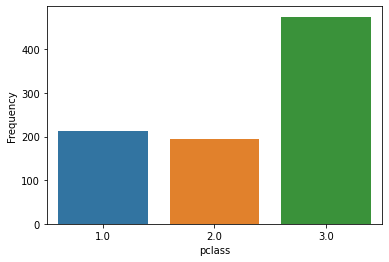

In [24]:
# Distribuição da feature pclass


g = sns.countplot(x = X_train["pclass"])
g.set_xlabel("pclass")
g.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

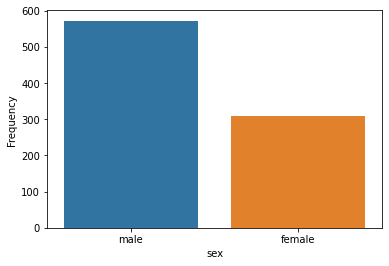

In [25]:
# Distribuição da feature sex

g = sns.countplot(x = X_train["sex"])
g.set_xlabel("sex")
g.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

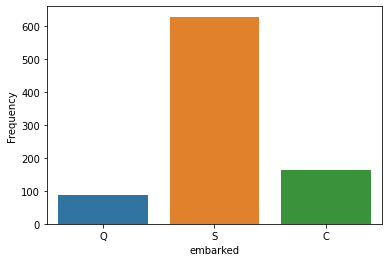

In [26]:
# Distribuição da feature embarked

g = sns.countplot(x = X_train["embarked"])
g.set_xlabel("embarked")
g.set_ylabel("Frequency")

In [27]:
# Transformar sexo em numérico
X_train['sex'] = X_train['sex'].map({"male":0, "female":1})
X_val['sex'] = X_val['sex'].map({"male":0, "female":1})
X_test['sex'] = X_test['sex'].map({"male":0, "female":1})


In [28]:
# Imputar embarked com modo

X_train['embarked'] = X_train['embarked'].fillna('S')
X_val['embarked'] = X_val['embarked'].fillna('S')
X_test['embarked'] = X_test['embarked'].fillna('S')

In [29]:
# Transformar em numérico

transformer = make_column_transformer(
    (OneHotEncoder(), ['embarked']),
    remainder='passthrough')

transformer.fit(X_train)

transformed_train = transformer.transform(X_train)
transformed_val= transformer.transform(X_val)
transformed_test= transformer.transform(X_test)

X_train = pd.DataFrame(
    transformed_train, 
    columns=transformer.get_feature_names()
)

X_val = pd.DataFrame(
    transformed_val, 
    columns=transformer.get_feature_names()
)

X_test = pd.DataFrame(
    transformed_test, 
    columns=transformer.get_feature_names()
)





C:\Users\glets\.conda\envs\ds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\glets\.conda\envs\ds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\glets\.conda\envs\ds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 3. Aplicação e avaliação do modelo

In [30]:
X_train.head(2)

,onehotencoder__x0_C,onehotencoder__x0_Q,onehotencoder__x0_S,age,fare,pclass,sex,sibsp,parch,ticket,cabin
0,0.0,1.0,0.0,-0.426683,-0.927385,3.0,0,0.0,0.0,371109,None
1,0.0,0.0,1.0,-0.350697,-0.33879,2.0,0,0.0,0.0,C.A. 29178,None


* Não usaremos ticket, cabin, sibsp e parch no modelo

In [31]:
X_train = X_train.drop(['ticket', 'cabin', 'sibsp', 'parch'], axis = 1)
X_val = X_val.drop(['ticket', 'cabin', 'sibsp', 'parch'], axis = 1)
X_test = X_test.drop(['ticket', 'cabin', 'sibsp', 'parch'], axis = 1)


In [32]:
#teste

model = KNN()
model.fit(np.array(X_train), np.array(y_train))
y_pred_val = model.predict(np.array(X_val), 4)
y_pred_test = model.predict(np.array(X_test), 4)


acc_val = accuracy_score(y_val, y_pred_val)
acc_test = accuracy_score(y_test, y_pred_test)
print(f"acurácia validação: {acc_val}, acurácia teste: {acc_test}")

acurácia validação: 0.7575757575757576, acurácia teste: 0.7652439024390244


### Executar o classificador para 30 k's pulando de 4 em 4 e apresente todas as acurácias utilizando o dataset de validação (Qual o melhor k?) [plotar um gráfico com os resultados].

In [33]:
results = []
k_list = [x*4 for x in range(1, 31)]

for k in k_list:
    model = KNN()
    model.fit(np.array(X_train), np.array(y_train))
    y_pred_val = model.predict(np.array(X_val), k)
    acc = accuracy_score(y_val, y_pred_val)
    results.append(acc)
    print(f"Para k = {k}, acurácia = {acc}")

Para k = 4, acurácia = 0.7575757575757576
Para k = 8, acurácia = 0.7777777777777778
Para k = 12, acurácia = 0.7575757575757576
Para k = 16, acurácia = 0.7777777777777778
Para k = 20, acurácia = 0.797979797979798
Para k = 24, acurácia = 0.7777777777777778
Para k = 28, acurácia = 0.7878787878787878
Para k = 32, acurácia = 0.8080808080808081
Para k = 36, acurácia = 0.7777777777777778
Para k = 40, acurácia = 0.7676767676767676
Para k = 44, acurácia = 0.7575757575757576
Para k = 48, acurácia = 0.7777777777777778
Para k = 52, acurácia = 0.7676767676767676
Para k = 56, acurácia = 0.7474747474747475
Para k = 60, acurácia = 0.7373737373737373
Para k = 64, acurácia = 0.7575757575757576
Para k = 68, acurácia = 0.7474747474747475
Para k = 72, acurácia = 0.7676767676767676
Para k = 76, acurácia = 0.7777777777777778
Para k = 80, acurácia = 0.7676767676767676
Para k = 84, acurácia = 0.7676767676767676
Para k = 88, acurácia = 0.7676767676767676
Para k = 92, acurácia = 0.7474747474747475
Para k = 96, a

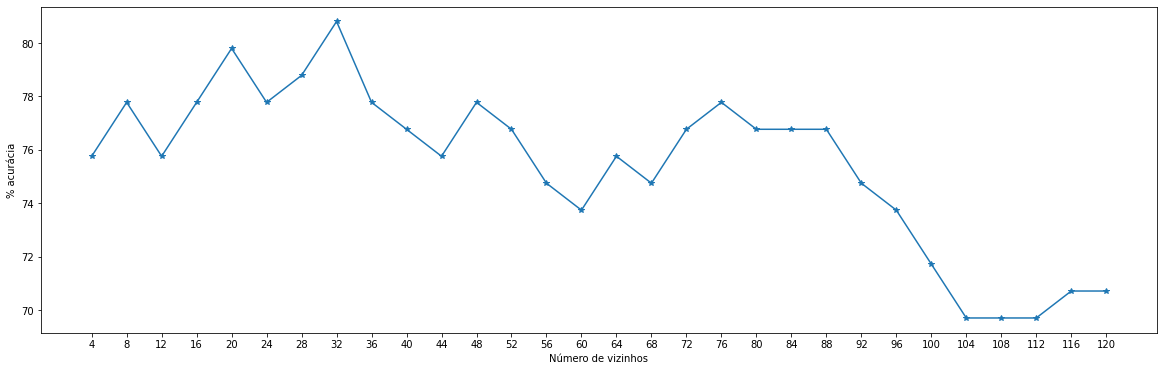

In [34]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(k_list, np.round(np.array(results)*100,2), marker='*')
ax.set_xlabel('Número de vizinhos')
ax.set_ylabel('% acurácia')
ax.set_xticks(k_list)
plt.show()

### O Modelo com k = 32 vizinhos é o que tem melhor desempenho. 

In [35]:
model = KNN()
model.fit(np.array(X_train), np.array(y_train))
y_pred_val = model.predict(np.array(X_val), 32)
y_pred_test = model.predict(np.array(X_test), 32)


acc_val = accuracy_score(y_val, y_pred_val)
acc_test = accuracy_score(y_test, y_pred_test)
print(f"acurácia validação: {acc_val}, acurácia teste: {acc_test}")

acurácia validação: 0.8080808080808081, acurácia teste: 0.7926829268292683


In [36]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       206
           1       0.75      0.66      0.70       122

    accuracy                           0.79       328
   macro avg       0.78      0.77      0.77       328
weighted avg       0.79      0.79      0.79       328

